<a href="https://colab.research.google.com/github/cfoli/Multi-label-Medical-Image-Classification/blob/main/Multi_label_CNN_protein_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About

---



This notebook implements a CNN-based solution (EfficientnetV2) for the [***"Human Protein Atlas Image Classification" Kaggle challenge***](https://www.kaggle.com/competitions/human-protein-atlas-image-classification/overview).

It follows the *[LearnOpenCV](https://learnopencv.com/)*  tutorial implemented in [***this blog***](https://learnopencv.com/medical-multi-label/)  (Github: [***click here***](https://github.com/spmallick/learnopencv/blob/master/Medical_Multi-label_Classification_with_PyTorch_%26_Lightning/HPA_PT_lightning.ipynb))


**TASK:**

---


*  To predict the subcellular (i.e., organelle level) localization of human proteins within a cell using multi-channel fluorescence images from the Human Protein Atlas. Each image targets a single (typically unique) protein, fluorescently labeled in green, while other channels mark fixed cellular structures (blue: nucleus, red: cytoskeleton, yellow: endoplasmic reticulum). Since most images correspond to different protetins, the model must generalize localization patterns across many different proteins. Importantly, proteins may localize to multiple organelles, making this a multi-label classification problem..*

### Install third-party packages

---




*   lightning: *for high-level training loops, logging etc*
*   torchmetrics: *metrics for evaluating model performance*
*   torchinfo: *for model summaries*
*   requests: *for http requests (downloading files, interfacing w APIs etc)*
*   tensorboard: *for training logs and visualization*
*   gradio: *web UI for demos and model inspection*
*   tqdm, scikit-learn, seaborn



In [2]:
# Uncomment to install required packages

!pip uninstall -y lightning lightning-cloud fastapi pydantic
!pip install -U torchinfo lightning==2.0.1 torchmetrics==1.0.0\
               requests opencv-contrib-python tqdm tensorboard\
               scikit-learn seaborn gradio lightning-cloud==0.5.31 fastapi==0.88.0 pydantic==1.10.26

!pip uninstall -y kaggle kagglesdk
!pip install kaggle==1.6.17


Found existing installation: lightning 2.0.1
Uninstalling lightning-2.0.1:
  Successfully uninstalled lightning-2.0.1
Found existing installation: lightning-cloud 0.5.31
Uninstalling lightning-cloud-0.5.31:
  Successfully uninstalled lightning-cloud-0.5.31
Found existing installation: fastapi 0.88.0
Uninstalling fastapi-0.88.0:
  Successfully uninstalled fastapi-0.88.0
Found existing installation: pydantic 1.10.26
Uninstalling pydantic-1.10.26:
  Successfully uninstalled pydantic-1.10.26
  Using cached lightning-2.0.1-py3-none-any.whl.metadata (35 kB)
  Using cached gradio-6.3.0-py3-none-any.whl.metadata (16 kB)
  Using cached lightning_cloud-0.5.31-py3-none-any.whl.metadata (862 bytes)
  Using cached fastapi-0.88.0-py3-none-any.whl.metadata (24 kB)
  Using cached pydantic-1.10.26-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (155 kB)
INFO: pip is looking at multiple versions of gradio to determine which version is compatible with other requirements. This could ta

### Import libraries

---



In [3]:
import os
import shutil
import zipfile
import warnings
import platform
import requests
from glob import glob
from itertools import chain
from collections import Counter
from dataclasses import dataclass

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TV_transforms
from torchvision.utils import make_grid
from torchvision.ops import sigmoid_focal_loss

import lightning.pytorch as torch_light
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics import MeanMetric
from torchmetrics.classification import MultilabelF1Score

from torchinfo import summary

In [4]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')
# torch.backends.cudnn.conv.fp32_precision = 'tf32'

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Filter userwarnings.
warnings.filterwarnings(action="ignore", category=UserWarning)

# Set Seaborn color palette
sns.set_palette(sns.color_palette("rocket_r"))

# To render the matplotlib figure in the notebook.
%matplotlib inline


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


### Configure parameters

In [5]:
BASE_DIR = os.path.join(os.getcwd(), "datasets")

In [6]:
# Import kaggle API token file
from google.colab import files
files.upload() # This will prompt you to select and upload the file

# Then move and secure the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [11]:
dataConfig = {
    # Image & label properties
    "IMAGE_SIZE": (384, 384),          # Resize images to (W, H)
    "NUM_CHANNELS":    3,                     # RGB images
    "NUM_CLASSES": 10,                 # Number of output labels
    "VALID_PCT":   0.1,                  # Fraction of training data for validation

    # ImageNet normalization (for pretrained backbones)
    "MEAN": (0.485, 0.456, 0.406),
    "STD":  (0.229, 0.224, 0.225),

    # Dataset paths
    "TRAIN_IMG_DIR": os.path.join(BASE_DIR, "Human protein atlas", "train"),
    "TEST_IMG_DIR":  os.path.join(BASE_DIR, "Human protein atlas", "test"),
    "TRAIN_CSV_DIR":     os.path.join(BASE_DIR, "Human protein atlas", "train.csv"),
    "TEST_CSV_DIR":      os.path.join(BASE_DIR, "submission.csv"),
}


trainingConfig = {
    # Training loop parameters
    "BATCH_SIZE": 64,                  # Reduce if you hit OOM
    "NUM_EPOCHS": 30,
    "INIT_LR":    1e-4,                   # Initial learning rate

    # DataLoader settings
    "NUM_WORKERS": 0 if platform.system() == "Windows" else os.cpu_count(),

    # Optimizer & regularization
    "OPTIMIZER_NAME": "Adam",
    "WEIGHT_DECAY":   1e-4,

    # Scheduler configuration
    "USE_SCHEDULER": True,
    "SCHEDULER":     "multi_step_lr",

    # Multi-label prediction threshold
    "METRIC_THRESH": 0.4,

    # Model configuration
    "MODEL_NAME":      "efficientnet_v2_s",
    "FREEZE_BACKBONE": False,
}



In [15]:
# labels dict with text labels as dictionary entries
labels_dict_text = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

# labels dict with text labels as dictionary keys
label_dict_idx = {val: key_ for key_, val in labels_dict_text.items()}


### Download and plot example images

---



In [8]:
# Download sample images with only one class per image.
# this is a curated dataset by learnOpenCV

URL = r"https://www.dropbox.com/scl/fi/caktugsvdbhnjoju5j78q/per_class_imgs.zip?rlkey=fu7q7fgpbrclxldq0xq9r2leb&dl=1"

# download zip file
file = requests.get(URL)

# save zip file
open("per_class_imgs.zip", "wb").write(file.content)

# load and extract contents of zip file
with zipfile.ZipFile("per_class_imgs.zip") as f:
    f.extractall(".")


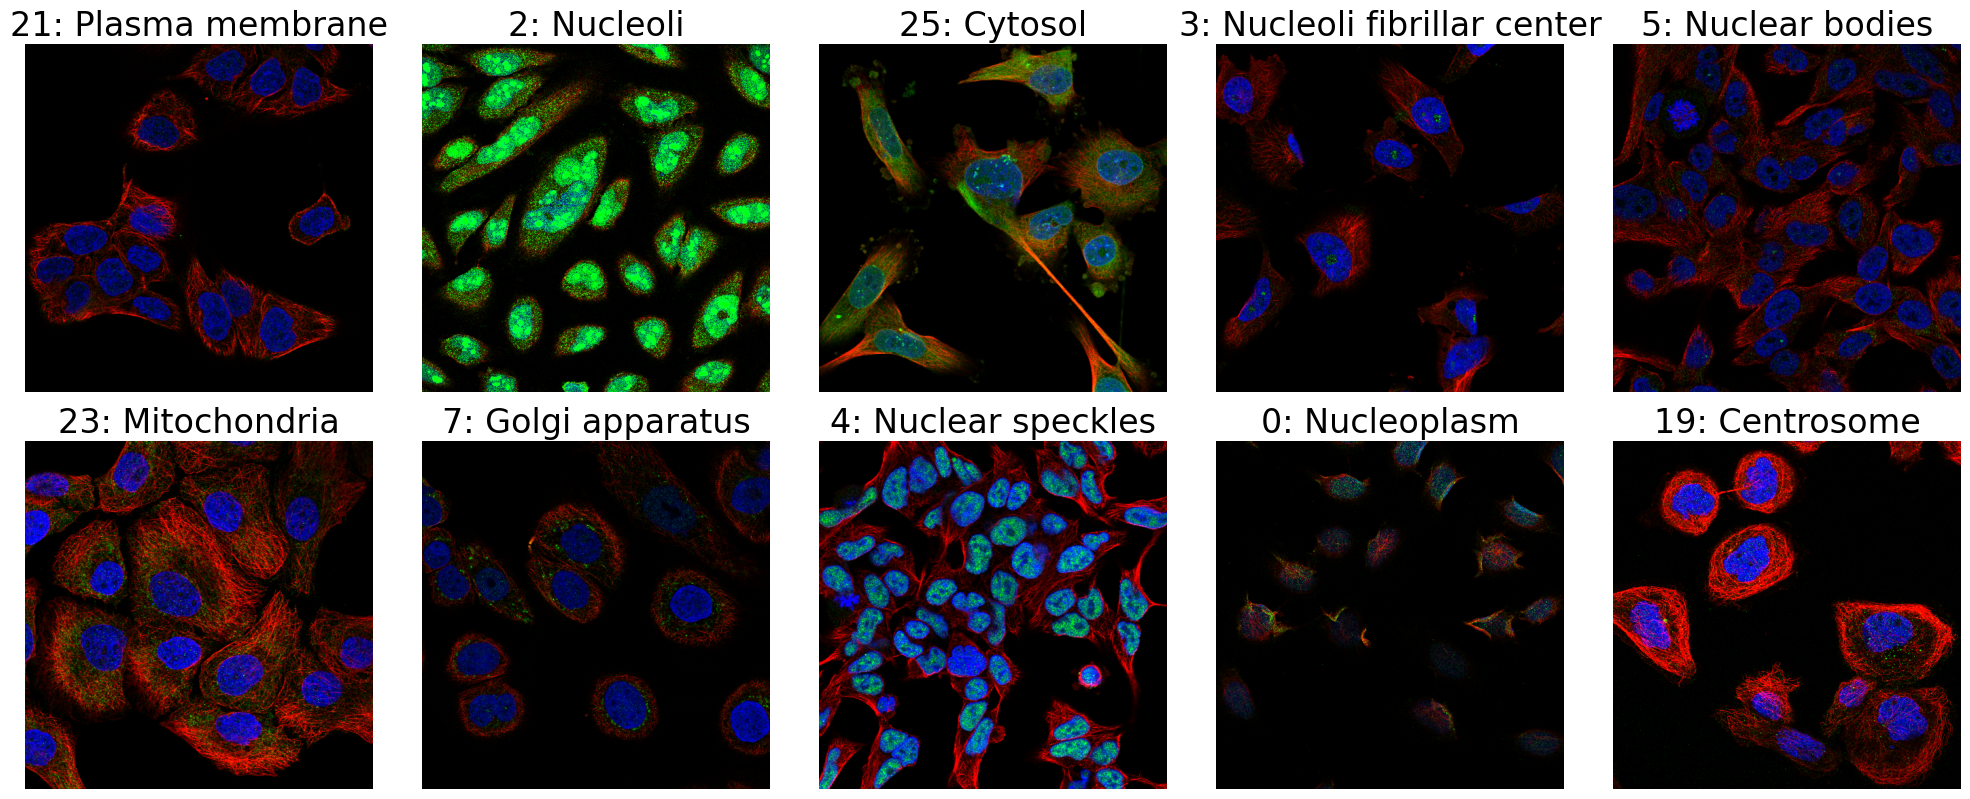

In [9]:
images_ = []
class_names = []

# Walk through each directory in main dataset folder. Each directory contains images for one class
for directory, _, files in os.walk("per_class_imgs"):

    # skip empty folders
    if not len(files):
        continue

    # extract class name from full folder directory name
    class_name = os.path.split(directory)[-1]

    # collect all images (.png) within class folder
    class_images = glob(directory + os.sep + "*.png")

    # pick a random image to plot for current class
    rand_image = np.random.choice(class_images, size=1, replace=False)[0]

    # load image, convert to numpy array for plotting
    image = Image.open(rand_image).convert("RGB")
    image = np.asarray(image.resize((512, 512)))

    images_.append(image)
    class_names.append(class_name)

# plot example images
plt.figure(figsize=(20, 20))

for idx, (image, class_name) in enumerate(zip(images_, class_names), 1):
    plt.subplot(5, 5, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{label_dict_idx[class_name]}: {class_name}", fontsize=24)

plt.tight_layout()
plt.show()


### Define helper functions

---



In [9]:
# **************************************************************************
def convert_str_to_multihot(label: list, num_classes=10):
    """This functions converts labels into multi-hot encoding"""

    target = torch.zeros(num_classes)
    for l in str(label).split(" "):
        target[int(l)] = 1.0
    return target

# **************************************************************************
def convert_multihot_to_str(
    target: list,
    text_labels: bool = False,
    threshold: float = 0.4,
    cls_labels: dict = None):
    """This function converts the labels from
    probablities to outputs or string representations
    """

    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(cls_labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)


# **************************************************************************
# This function is used for reversing the Normalization step performed
# during image preprocessing.
# Note the mean and std values must match the ones used.
# This is useful for visualizing images
def reverse_imagenet_normalization(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""

    for c in range(dataConfig["NUM_CHANNELS"]):

        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)


# **************************************************************************
# This is a custom PyTorch Dataset class designed to load images and labels (if available) for each set. It loads images, resizes them, applies specified data augmentation transforms, and converts string labels to multi-hot vectors.
class createDataset(Dataset):
    """
    Parse raw data to form a Dataset of (X, y).
    """

    def __init__(self, *, df, root_dir, img_size, transforms=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.img_size = img_size
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row["Image"]
        img_fname = self.root_dir + os.sep + str(img_id) + ".png"

        img = Image.open(img_fname).convert("RGB") # Forces RGB (3 channels)
        img = img.resize(self.img_size, resample=3)
        img = self.transforms(img)

        if self.is_test:
            return img, img_id

        return img, convert_str_to_multihot(row["Label"])


# **************************************************************************
# create torch lightning (LightningDataModule) class for cleanly encapsulating dataset downloading, splitting, transforms, and dataloaders so the training code never touches data preprocessing/plumbing.
class createDataModule(torch_light.LightningDataModule):
    def __init__(
        self,
        *,
        num_classes=10,
        valid_pct=0.1,
        resize_to=(384, 384),
        batch_size=32,
        num_workers=0,
        pin_memory=False,
        shuffle_validation=False):
        super().__init__()

        self.num_classes = num_classes
        self.valid_pct   = valid_pct
        self.resize_to   = resize_to
        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.pin_memory  = pin_memory
        self.shuffle_validation = shuffle_validation

        self.train_tfs = TV_transforms.Compose(
            [
                TV_transforms.RandomAffine(
                    degrees=40,
                    translate=(0.01, 0.12),
                    shear=0.05,
                ),
                TV_transforms.RandomHorizontalFlip(),
                TV_transforms.RandomVerticalFlip(),
                TV_transforms.ToTensor(),
                TV_transforms.Normalize(dataConfig["MEAN"], dataConfig["STD"], inplace=True),
                TV_transforms.RandomErasing(inplace=True),
            ]
        )

        self.valid_tfs = TV_transforms.Compose(
            [
                TV_transforms.ToTensor(),
                TV_transforms.Normalize(dataConfig["MEAN"], dataConfig["STD"], inplace=True),
            ]
        )
        self.test_tfs = self.valid_tfs


    def prepare_data(self):
        # Download dataset.
        if not os.path.exists(os.path.join(dataConfig["TRAIN_CSV"])):
            KAGGLE_DIR = os.path.join(os.path.expanduser("~"), ".kaggle")
            KAGGLE_JSON_PATH = os.path.join(KAGGLE_DIR, "kaggle.json")

            if not os.path.exists(KAGGLE_JSON_PATH):
                os.makedirs(KAGGLE_DIR, exist_ok=True)
                shutil.copyfile("kaggle.json", KAGGLE_JSON_PATH)
                os.chmod(KAGGLE_JSON_PATH, 0o600)

            # print("Downloading 512x512 sized dataset...", end="")
            # !kaggle datasets download -q aakashns/jovian-pytorch-z2g -p datasets --unzip

            print("Downloading 384x384 sized dataset...", end="")
            !kaggle datasets download -q learnopencvblog/human-protein-atlas-384x384 -p {BASE_DIR} --unzip
            print("Done")

    def setup(self, stage=None):
        np.random.seed(42)
        data_df = pd.read_csv(dataConfig["TRAIN_CSV"])
        msk = np.random.rand(len(data_df)) < (1.0 - self.valid_pct)
        train_df = data_df[msk].reset_index()
        valid_df = data_df[~msk].reset_index()

        # train_labels = list(chain.from_iterable([i.strip().split(" ") for i in train_df["Label"].values]))
        # class_weights = compute_class_weight("balanced", classes=list(range(self.num_classes)),
        #                                      y=[int(i) for i in train_labels])
        # self.class_weights = torch.tensor(class_weights)

        img_size = dataConfig["IMAGE_SIZE"]
        self.train_ds = createDataset(
            df=train_df, img_size=img_size, root_dir=dataConfig["TRAIN_IMG_DIR"], transforms=self.train_tfs
        )

        self.valid_ds = createDataset(
            df=valid_df, img_size=img_size, root_dir=dataConfig["TRAIN_IMG_DIR"], transforms=self.valid_tfs
        )

        test_df = pd.read_csv(dataConfig["TEST_CSV"])
        self.test_ds = createDataset(
            df=test_df, img_size=img_size, root_dir=dataConfig["TEST_IMG_DIR"], transforms=self.test_tfs, is_test=True
        )

        print(f"Number of images :: Training: {len(self.train_ds)}, Validation: {len(self.valid_ds)}, Testing: {len(self.test_ds)}\n")

    def train_dataloader(self):
        # Create a train dataloader.
        train_loader = DataLoader(
            self.train_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=True, num_workers=self.num_workers
        )
        return train_loader

    def val_dataloader(self):
        # Create validation dataloader object.
        valid_loader = DataLoader(
            self.valid_ds, batch_size=self.batch_size, pin_memory=self.pin_memory,
            shuffle=self.shuffle_validation, num_workers=self.num_workers
        )
        return valid_loader

    def test_dataloader(self):
        # Create test dataloader object.
        test_loader = DataLoader(
            self.test_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=False, num_workers=self.num_workers
        )
        return test_loader


### Download and format training data

---



In [10]:
%%time

# instantiate data module class
data_module = createDataModule(
    num_classes = dataConfig["NUM_CLASSES"],
    batch_size  = 32,
    num_workers = 0
)

# Donwload dataset.
data_module.prepare_data()

# Split datset into training, validation set.
data_module.setup()


Dataset URL: https://www.kaggle.com/datasets/learnopencvblog/human-protein-atlas-384x384
License(s): unknown
Done
Number of images :: Training: 17335, Validation: 1901, Testing: 8243

CPU times: user 335 ms, sys: 55.7 ms, total: 391 ms
Wall time: 2min


In [14]:

data_df = pd.read_csv(dataConfig["TRAIN_CSV_DIR"])
data_df.head(3)

Image Label
0  19567     9
1  29993   6 4
2  17186   1 4

In [18]:
all_labels = list(chain.from_iterable([i.strip().split(" ") for i in data_df["Label"].values]))
c_val = Counter(all_labels)

n_keys = c_val.keys()
max_idx = max(n_keys)

counts = pd.DataFrame(
    {
        "Label": [labels_dict_text[int(key)] for key in c_val.keys()],
        "Count": [val for val in c_val.values()],
    }
)

rev_label2id = {value: key for key, value in labels_dict_text.items()}
counts["Class ID"]  = [rev_label2id[label] for label in counts["Label"]]
counts = counts.set_index("Class ID")

counts = counts.sort_values(by="Count", ascending=False)
counts.style.background_gradient(cmap="Oranges")


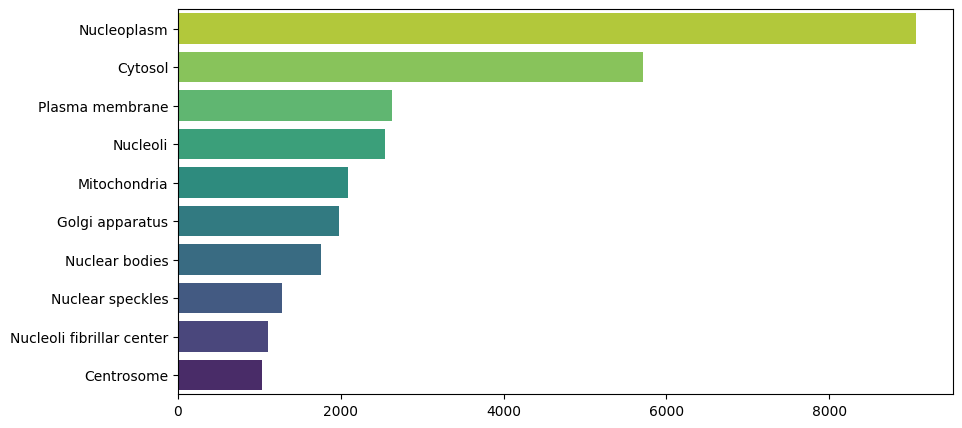

In [25]:
plt.figure(figsize=(10,5))
x = counts["Count"].values
y = counts["Label"].values
sns.barplot(y=y, x=x, order=y, palette="viridis_r", hue=y, legend=False);


In [26]:
# Get the validation data loader.
valid_loader = data_module.val_dataloader()


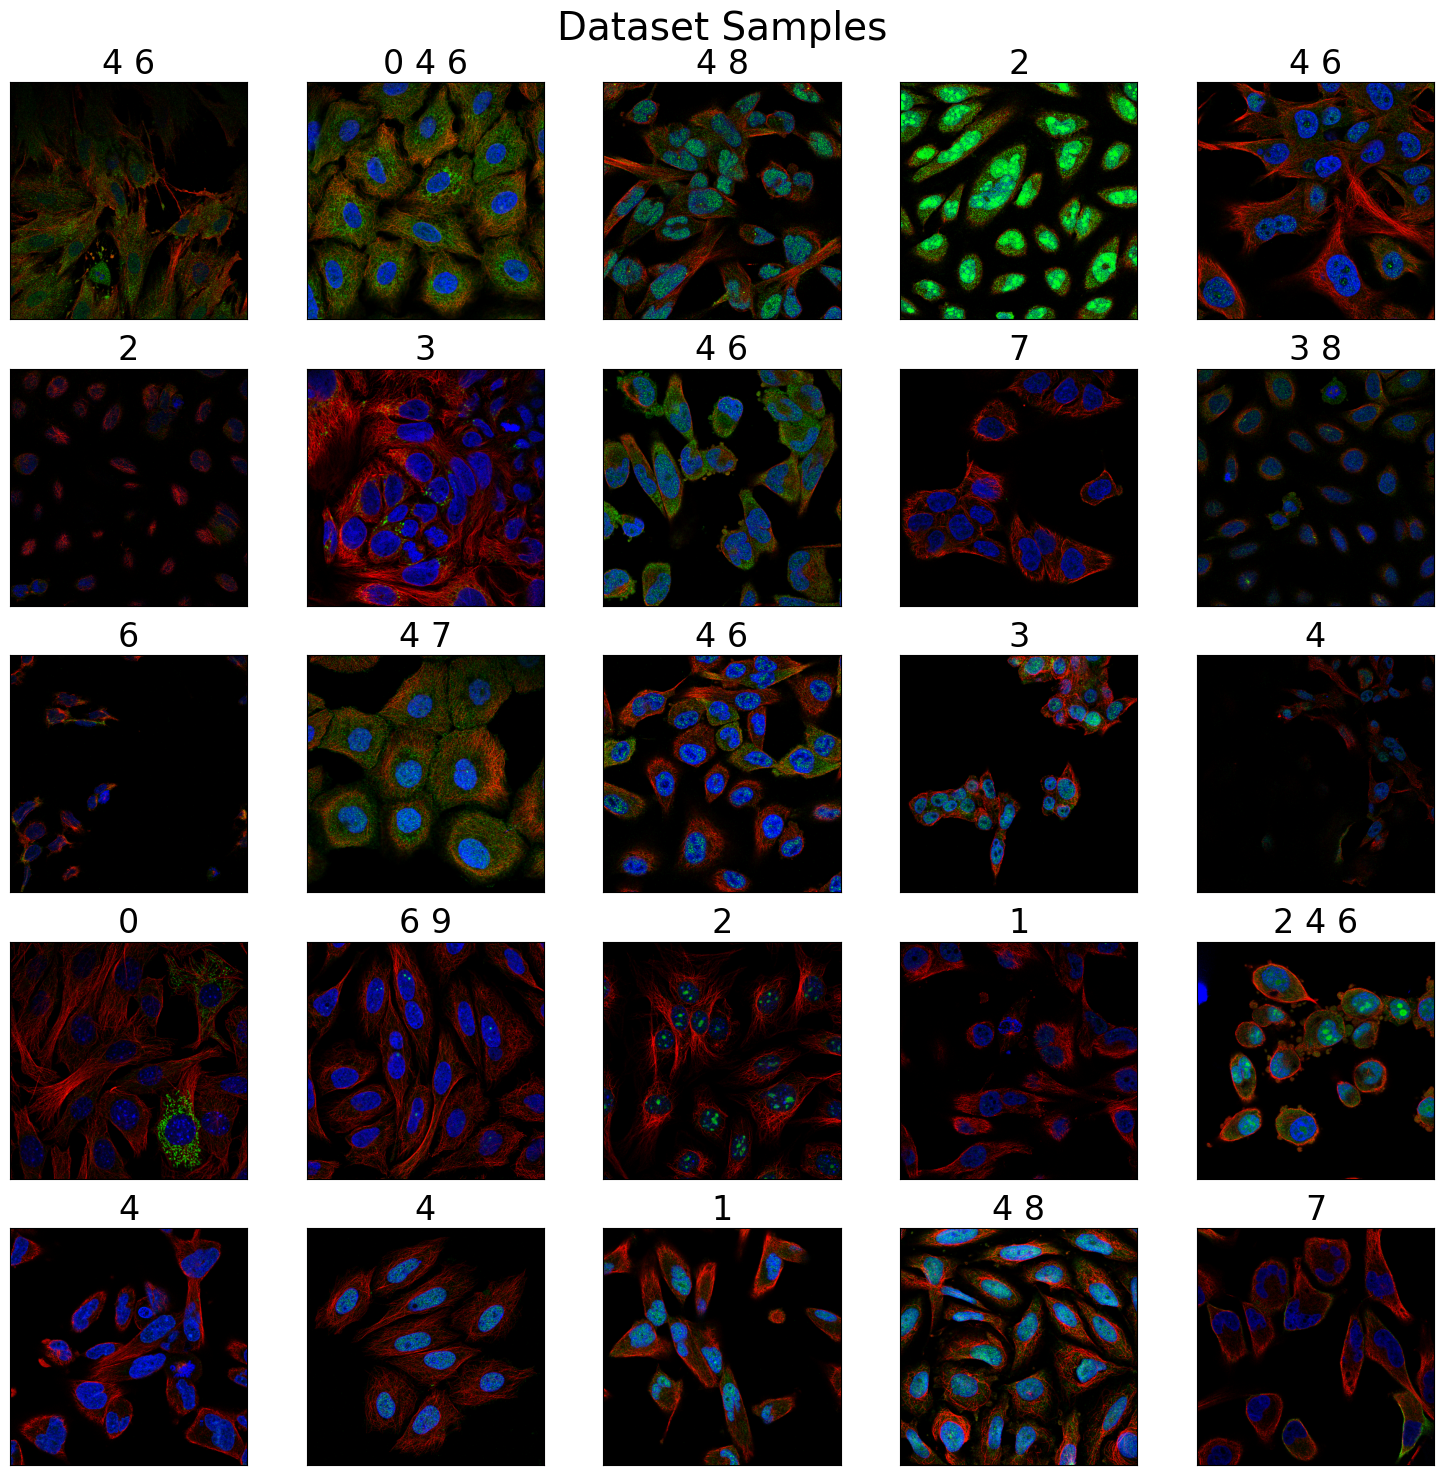

In [28]:
plt.figure(figsize=(15, 15))

for X, y in valid_loader:

    images = reverse_imagenet_normalization(X, mean=dataConfig["MEAN"], std=dataConfig["STD"]).permute(0, 2, 3, 1).numpy()
    targets = y.numpy()


    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])

        target = " ".join([str(idx) for idx, cls_id in enumerate(targets[i]) if cls_id])
        plt.title(f"{target}", fontsize=24)

    plt.suptitle('Dataset Samples', fontsize=28)
    plt.tight_layout()
    plt.show()
    plt.close()
    break


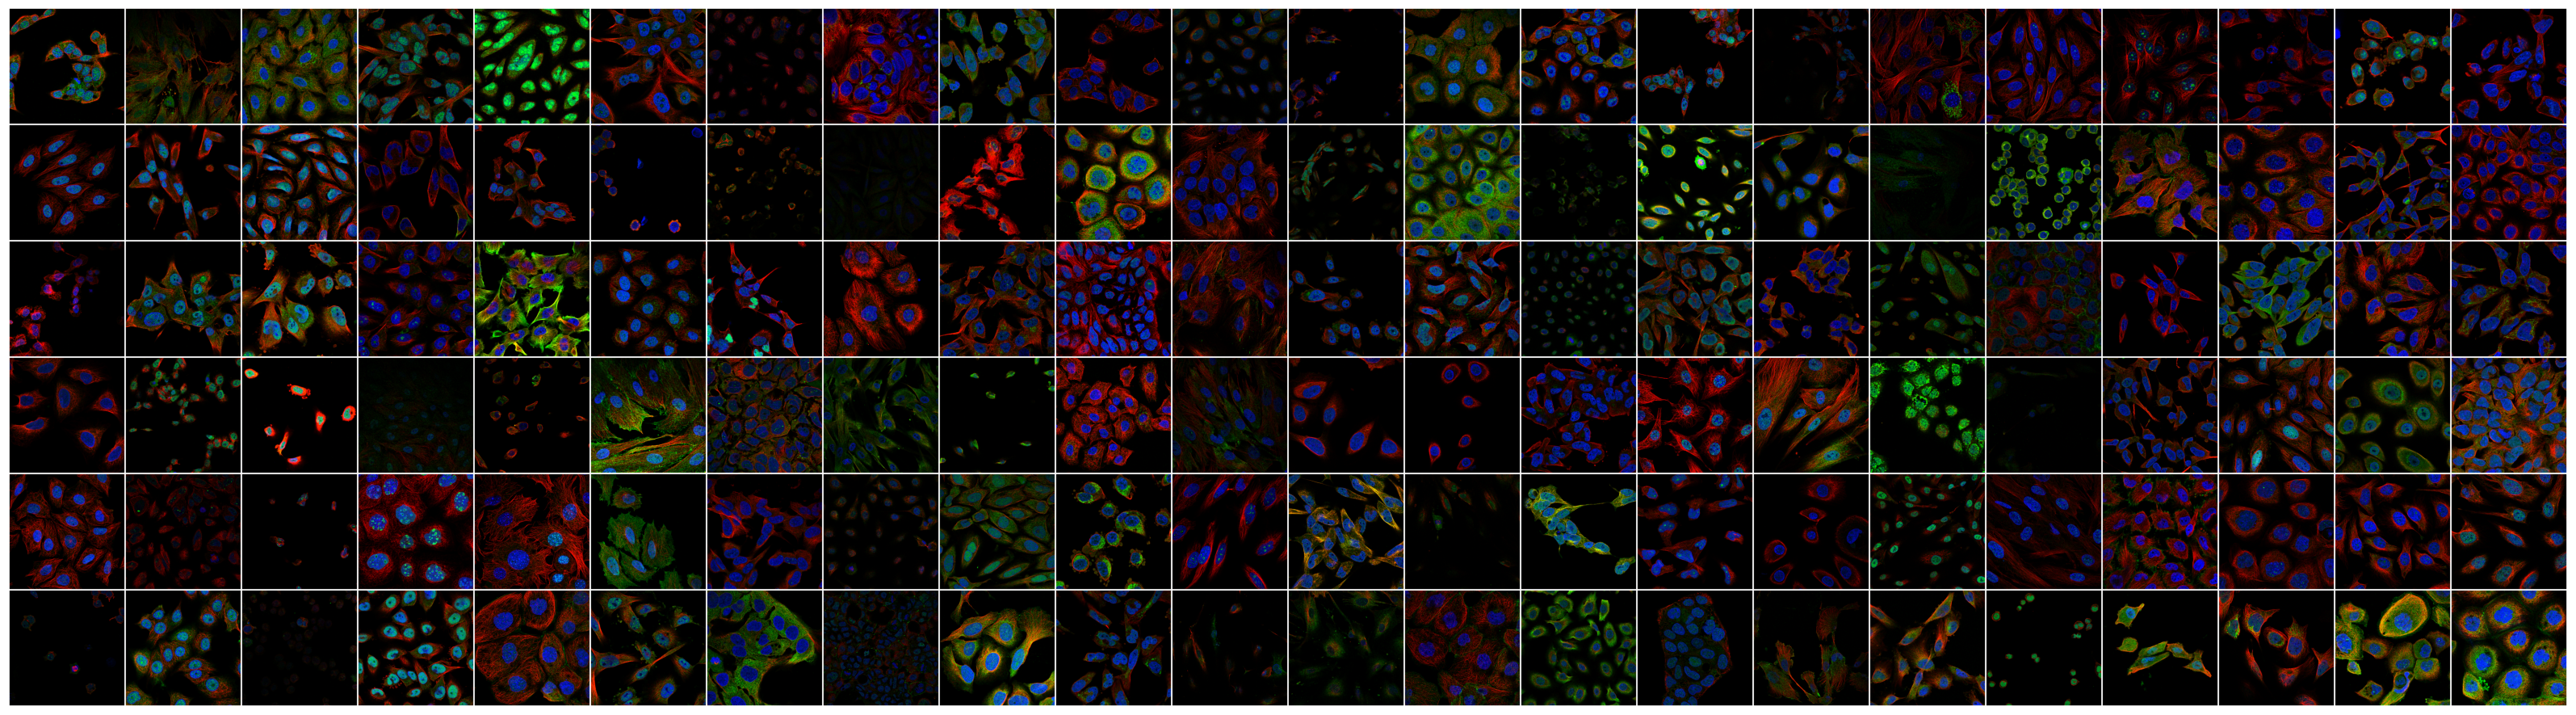

In [30]:
data_module.batch_size = 132
data_module.resize_to = (128, 128)
val_data_loader = data_module.val_dataloader()

batch = next(iter(val_data_loader))
images = reverse_imagenet_normalization(batch[0], mean=dataConfig["MEAN"], std=dataConfig["STD"])


plt.figure(figsize=(32, 32))

grid_img = make_grid(images, nrow=22, padding=5, pad_value=1.0)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.savefig("medical_images_grid.png", bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close;


### Initialize pretrained model

---



In [32]:
# helper function for loading pretrained torch vision model
def get_model(model_name: str, num_classes: int, freeze_backbone: bool= True):
    """A helper function to load and prepare any classification model
    available in Torchvision for transfer learning or fine-tuning."""

    model = getattr(torchvision.models, model_name)(weights="DEFAULT")

    if freeze_backbone:
        # Set all layer to be non-trainable
        for param in model.parameters():
            param.requires_grad = False

    model_childrens = [name for name, _ in model.named_children()]

    try:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}")[-1].in_features
    except Exception as e:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}").in_features

    new_output_layer = nn.Linear(
        in_features=final_layer_in_features,
        out_features=num_classes
    )

    try:
        getattr(model, f"{model_childrens[-1]}")[-1] = new_output_layer
    except:
        setattr(model, model_childrens[-1], new_output_layer)

    return model


In [34]:
# import torchvision.models as models
# resnet18 = models.resnet18()
# vgg16 = models.vgg16()
# googlenet = models.googlenet()

model = get_model(
    model_name=trainingConfig["MODEL_NAME"], # efficientnet_v2_s
    num_classes=dataConfig["NUM_CLASSES"],
    freeze_backbone=False)

summary(
    model,
    input_size=(1, dataConfig["NUM_CHANNELS"], *dataConfig["IMAGE_SIZE"][::-1]),
    depth=2,
    device="cpu",
    col_names=["output_size", "num_params", "trainable"])


Layer (type:depth-idx)                                  Output Shape              Param #                   Trainable
EfficientNet                                            [1, 10]                   --                        True
├─Sequential: 1-1                                       [1, 1280, 12, 12]         --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 24, 192, 192]         696                       True
│    └─Sequential: 2-2                                  [1, 24, 192, 192]         10,464                    True
│    └─Sequential: 2-3                                  [1, 48, 96, 96]           303,552                   True
│    └─Sequential: 2-4                                  [1, 64, 48, 48]           589,184                   True
│    └─Sequential: 2-5                                  [1, 128, 24, 24]          917,680                   True
│    └─Sequential: 2-6                                  [1, 160, 24, 24]          3,463,840

In [36]:
class Model(torch_light.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 10,
        freeze_backbone: bool = False,
        init_lr: float = 0.001,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        f1_metric_threshold: float = 0.4):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(
            model_name=self.hparams.model_name,
            num_classes=self.hparams.num_classes,
            freeze_backbone=self.hparams.freeze_backbone,
        )

        # Intialize loss class.
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1   = MultilabelF1Score(num_labels=self.hparams.num_classes,
                                                 average="macro", threshold=self.hparams.f1_metric_threshold)
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1   = MultilabelF1Score(num_labels=self.hparams.num_classes,
                                                 average="macro", threshold=self.hparams.f1_metric_threshold)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
        loss = self.loss_fn(logits, target)

        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_f1(logits, target)

        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True)
        self.log("train/batch_f1",   self.mean_train_f1,   prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True)
        self.log("train/f1",   self.mean_train_f1,   prog_bar=True)
        self.log("step", self.current_epoch)

    def validation_step(self, batch, *args, **kwargs):
        data, target = batch  # Unpacking validation dataloader tuple
        logits = self(data)
        loss = self.loss_fn(logits, target)

        self.mean_valid_loss.update(loss, weight=data.shape[0])
        self.mean_valid_f1.update(logits, target)

    def on_validation_epoch_end(self):
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid/f1",   self.mean_valid_f1,   prog_bar=True)
        self.log("step", self.current_epoch)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer_name)(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.hparams.init_lr,
            weight_decay=self.hparams.weight_decay,
        )

        if self.hparams.use_scheduler:
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[self.trainer.max_epochs // 2,],
                gamma=0.1,
            )

            # The lr_scheduler_config is a dictionary that contains the scheduler
            # and its associated configuration.
            lr_scheduler_config = {
                "scheduler": lr_scheduler,
                "interval": "epoch",
                "name": "multi_step_lr",
            }
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

        else:
            return optimizer



In [37]:

# Seed everything for reproducibility.
torch_light.seed_everything(42, workers=True)

model = Model(
    model_name          = trainingConfig["MODEL_NAME"],
    num_classes         = dataConfig["NUM_CLASSES"],
    freeze_backbone     = trainingConfig["FREEZE_BACKBONE"],
    init_lr             = trainingConfig["INIT_LR"],
    optimizer_name      = trainingConfig["OPTIMIZER_NAME"],
    weight_decay        = trainingConfig["WEIGHT_DECAY"],
    use_scheduler       = trainingConfig["USE_SCHEDULER"],
    f1_metric_threshold = trainingConfig["METRIC_THRESH"])

data_module = createDataModule(
    num_classes = dataConfig["NUM_CLASSES"],
    valid_pct   = dataConfig["VALID_PCT"],
    resize_to   = dataConfig["IMAGE_SIZE"],
    batch_size  = trainingConfig["BATCH_SIZE"],
    num_workers = trainingConfig["NUM_WORKERS"],
    pin_memory  = torch.cuda.is_available())

# Creating ModelCheckpoint callback.
# Checkpoints by default will be saved in Trainer - default_root_dir which is "lightning_logs".
model_checkpoint = ModelCheckpoint(
    monitor  = "valid/f1",
    mode     = "max",
    filename = "ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}",
    auto_insert_metric_name = False)

# Creating a learning rate monitor callback which will be plotted/added in the default logger.
lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")


INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.